The data has the following features:

1. datetime - hourly date + timestamp
2. season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather -
       1: Clear, Few clouds, Partly cloudy
       2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
       3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
       4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

Read in bikeshare.csv file and set it to a dataframe called bike.

In [5]:
bike <- read.csv('/kaggle/input/bike-share/bikeshare.csv')

In [6]:
head(bike)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


# **Exploratory Data Analysis**
**Create the scatterplot of count vs temp.** 

In [7]:
library(ggplot2)

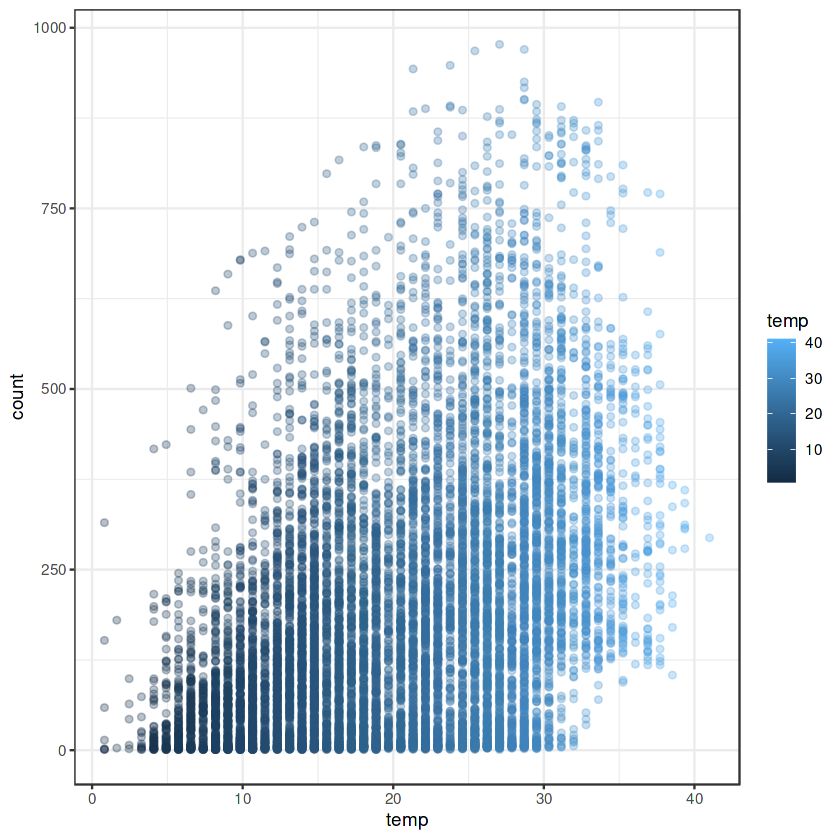

In [9]:
ggplot(bike, aes(temp,count)) + geom_point(alpha=0.3, aes(color=temp)) + theme_bw()

**Create a scatterplot of count vs datetime with color gradient based on temp.**

In [10]:
# Convert to Datetime in POSIXct format
bike$datetime <- as.POSIXct(bike$datetime)

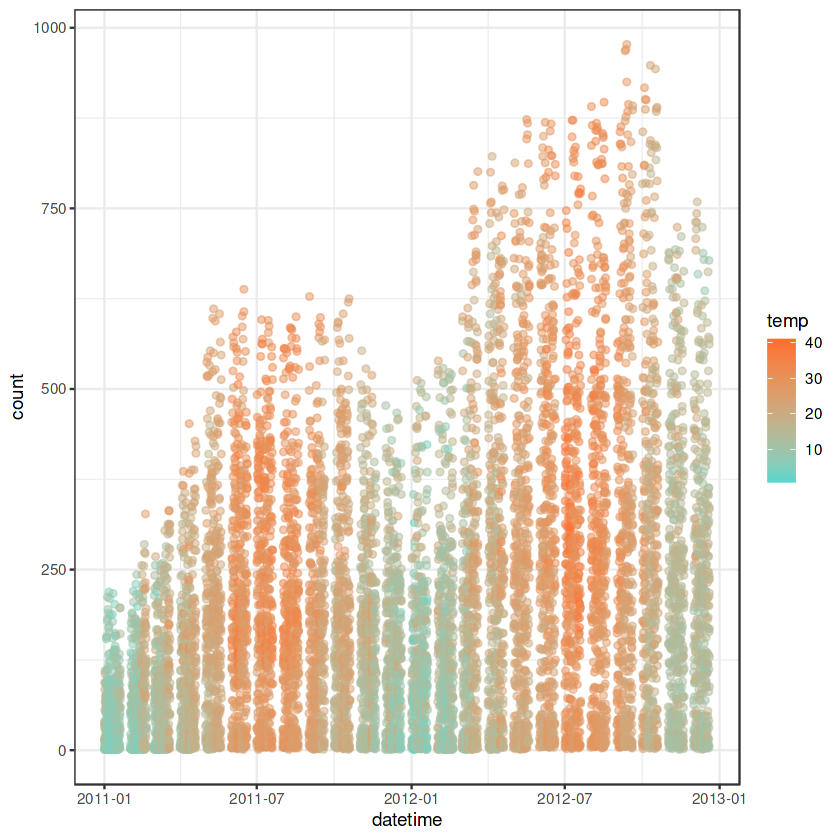

In [11]:
ggplot(bike,aes(datetime,count)) + geom_point(aes(color=temp),alpha = 0.5) + scale_color_continuous(low='#55D8CE',high='#FF6E2E') + theme_bw()

**Hopefully you noticed two things: A seasonality to the data, for winter and summer. Also that bike rental counts are increasing in general. This may present a problem with using a linear regression model if the data is non-linear. Let's have a quick overview of pros and cons right now of Linear Regression:**

**Pros:**

1. Simple to explain
2. Highly interpretable
3. Model training and prediction are fast
4. No tuning is required (excluding regularization)
5. Features don't need scaling
6. Can perform well with a small number of observations
7. Well-understood

**Cons:**

1. Assumes a linear relationship between the features and the response
2. Performance is (generally) not competitive with the best supervised learning methods due to high bias
3. Can't automatically learn feature interactions

# **Correlation between temp and count**

In [12]:
cor(bike[,c('temp','count')])

,temp,count
temp,1.0000000,0.3944536
count,0.3944536,1.0000000


**Create a box plot for exploring the season data.**

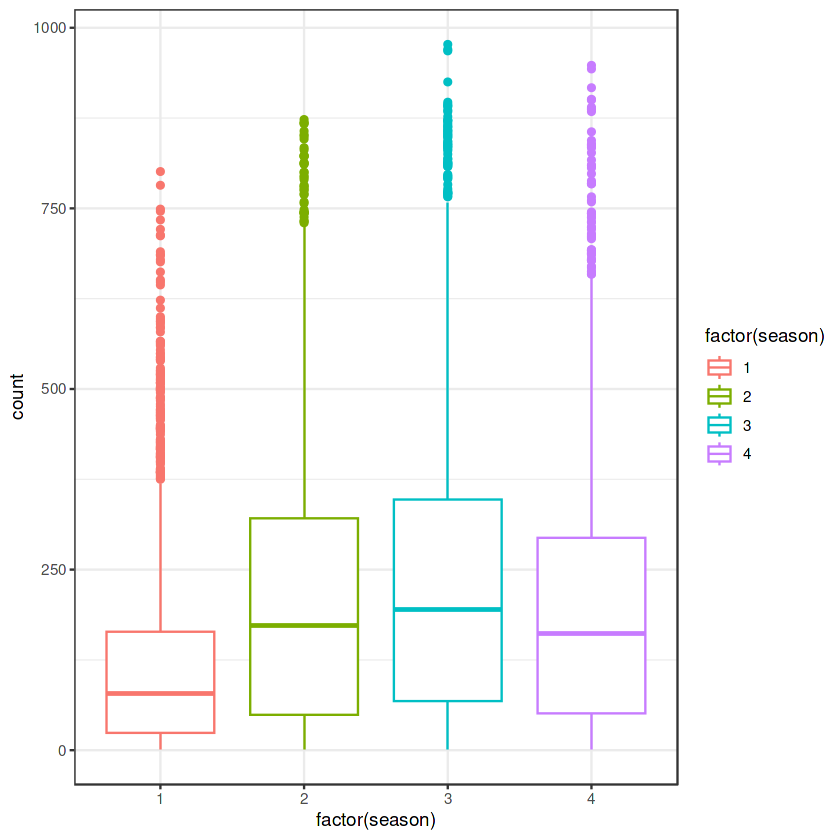

In [13]:
ggplot(bike, aes(factor(season),count)) + geom_boxplot(aes(color=factor(season))) + theme_bw()

**Notice what this says:**

1. A line can't capture a non-linear relationship.
2. There are more rentals in winter than in spring

**We know of these issues because of the growth of rental count, this isn't due to the actual season!**

# **Feature Engineering**

**Create an Hour coloumn that takes the hour from the datetime column**

In [15]:
bike$hour <- sapply(bike$datetime,function(x){format(x,"%H")})
head(bike)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<chr>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,00
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,01
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,02
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,03
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,04
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,05


**Create a scatterplot of count versus hour, with color scale based on temp.**

In [16]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




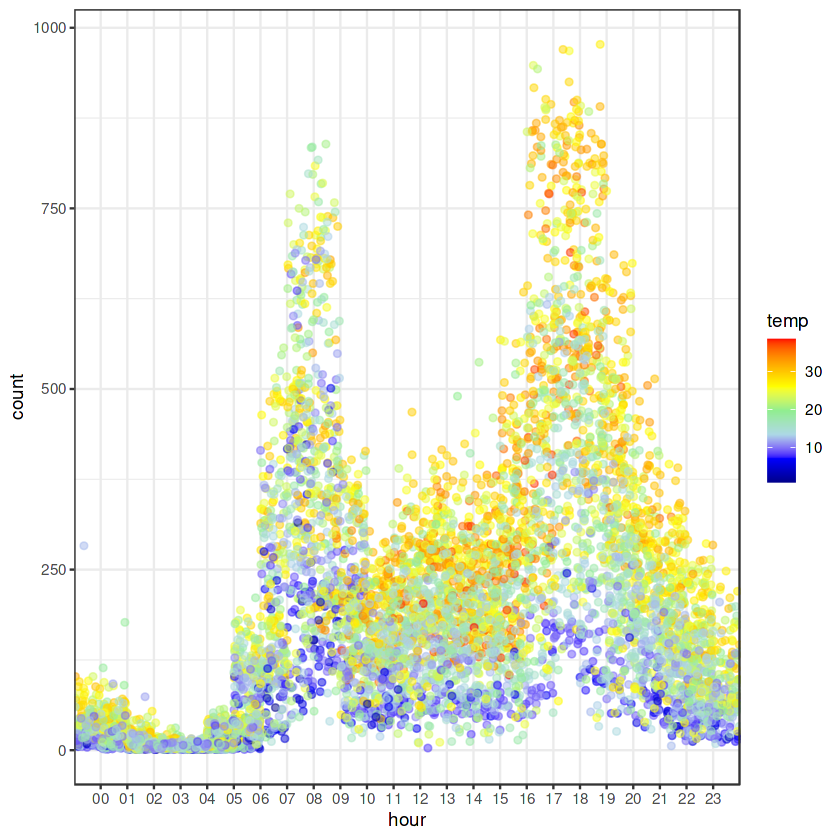

In [20]:
pl <- ggplot(filter(bike,workingday==1),aes(hour,count))
pl <- pl + geom_point(position=position_jitter(w=1,h=0),aes(color=temp),alpha=0.5)
pl <- pl+ scale_color_gradientn(colours = c('dark blue','blue','light blue','light green','yellow','orange','red'))
pl <- pl + theme_bw()
pl

**Create same plot for non working days**

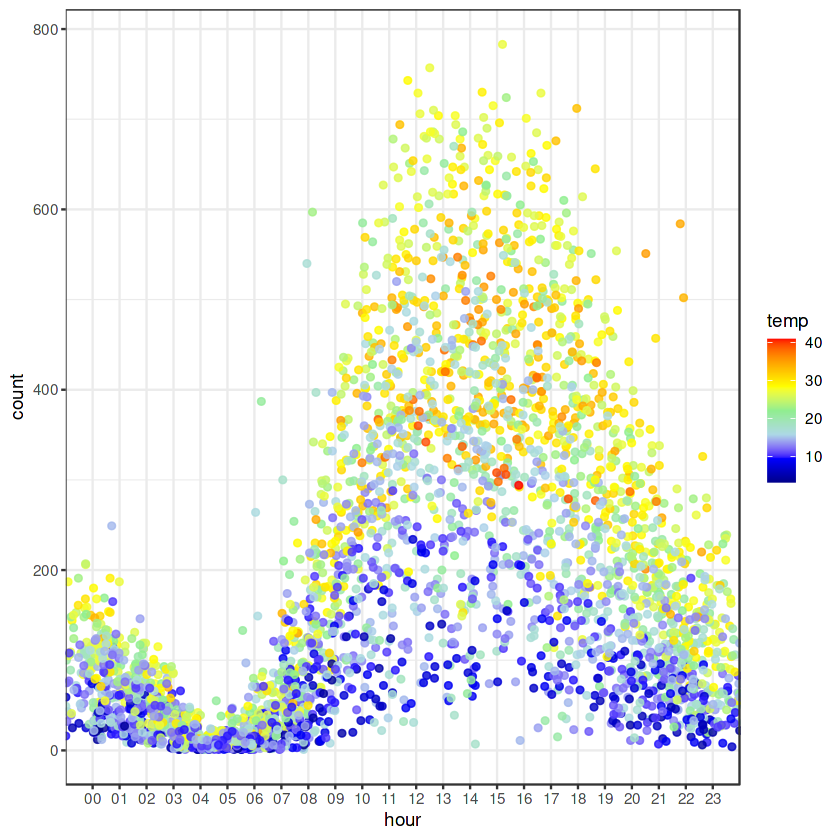

In [21]:
pl <- ggplot(filter(bike,workingday==0),aes(hour,count))
pl <- pl + geom_point(position=position_jitter(w=1,h=0),aes(color=temp),alpha=0.8)
pl <- pl+ scale_color_gradientn(colours = c('dark blue','blue','light blue','light green','yellow','orange','red'))
pl <- pl + theme_bw()
pl

**You should have noticed that working days have peak activity during the morning (~8am) and right after work gets out (~5pm), with some lunchtime activity. While the non-work days have a steady rise and fall for the afternoon**

# **Building the Model**

**Use lm() to build a model that predicts count based solely on the temp feature**

In [22]:
temp.model <- lm(count ~ temp,bike)

**Get the summary of temp.model**

In [23]:
summary(temp.model)


Call:
lm(formula = count ~ temp, data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-293.32 -112.36  -33.36   78.98  741.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0462     4.4394   1.362    0.173    
temp          9.1705     0.2048  44.783   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 166.5 on 10884 degrees of freedom
Multiple R-squared:  0.1556,	Adjusted R-squared:  0.1555 
F-statistic:  2006 on 1 and 10884 DF,  p-value: < 2.2e-16


**Interpreting the intercept (β0):**

1. It is the value of y when x=0.
2. Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
3. Note: It does not always make sense to interpret the intercept.

**Interpreting the "temp" coefficient (β1):**

1. It is the change in y divided by change in x, or the "slope".
2. Thus, a temperature increase of 1 degree Celsius is associated with a rental increase of 9.17 bikes.
3. This is not a statement of causation.
4. β1 would be negative if an increase in temperature was associated with a decrease in rentals.

**How many bike rentals would we predict if the temperature was 25 degrees Celsius? Calculate this two ways:**

Using the values we just got above
Using the predict() function

In [24]:
temp.test <- data.frame(temp=c(25))
predict(temp.model,temp.test)

1 
235.3097

**Use sapply() and as.numeric to change the hour column to a column of numeric values.**

In [25]:
bike$hour <- sapply(bike$hour,as.numeric)

In [26]:
model <- lm(count ~ . - casual - registered - datetime - atemp, bike)

In [27]:
summary(model)


Call:
lm(formula = count ~ . - casual - registered - datetime - atemp, 
    data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-324.61  -96.88  -31.01   55.27  688.83 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  46.91369    8.45147   5.551 2.91e-08 ***
season       21.70333    1.35409  16.028  < 2e-16 ***
holiday     -10.29914    8.79069  -1.172    0.241    
workingday   -0.71781    3.14463  -0.228    0.819    
weather      -3.20909    2.49731  -1.285    0.199    
temp          7.01953    0.19135  36.684  < 2e-16 ***
humidity     -2.21174    0.09083 -24.349  < 2e-16 ***
windspeed     0.20271    0.18639   1.088    0.277    
hour          7.61283    0.21688  35.102  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 147.8 on 10877 degrees of freedom
Multiple R-squared:  0.3344,	Adjusted R-squared:  0.3339 
F-statistic:   683 on 8 and 10877 DF,  p-value: < 2.2e-16


# **Conclusion**

**A linear model like the one we chose which uses OLS won't be able to take into account seasonality of our data, and will get thrown off by the growth in our dataset, accidentally attributing it towards the winter season, instead of realizing its just overall demand growing!.**